Conversion from CellRank pipeline
=================================
The aim of this notebook is to convert resulting analysis from CellRank into a principal tree that can be used by scFates

## Getting the best of both worlds

CellRank aims at identifying fate potentials by considering single cell dynamics as a Markov process (see [Lange et al., biorxiv, 2021](https://www.biorxiv.org/content/10.1101/2020.10.19.345983v2)). This is a great tool for finding the macrostates such as the "tips" of our trajectories, thanks to its powerful probabilistic approach. Here we propose to extend it by converting the fate probabilities into a principal tree, allowing easier interpretation of what is happening "in between" (early biases, bifurcations).

The conversion can be run with the single following command `scf.tl.cellrank_to_tree`, we will develop a bit more how this conversion is performed in the [related section](https://scfates.readthedocs.io/en/latest/Conversion_from_CellRank_pipeline.html#How-the-conversion-is-performed).

## Reproduction of CellRank notebook

Here we run a compressed version of one of CellRank preprint [notebook](https://github.com/theislab/cellrank_reproducibility/blob/main/notebooks/fig_2_pancreas_main/ML-2020-10-14_fig_2_and_3_pancreas_main.ipynb), without the plots.

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [2]:
import warnings
warnings.simplefilter("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = FutureWarning)
warnings.simplefilter("ignore", category = DeprecationWarning)

In [3]:
adata = cr.datasets.pancreas()
adata.var_names.name=None
adata.raw = adata # We want to keep all the genes for testing on the resulting tree 
scv.pp.filter_genes(adata,min_shared_counts=20)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

  0%|          | 0.00/33.5M [00:00<?, ?B/s]

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 20/88 cores)


  0%|          | 0/1078 [00:00<?, ?gene/s]

    finished (0:00:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Defaulting to `mode='monte_carlo'` and `n_samples=1000`
Computing transition matrix based on logits using `'monte_carlo'` mode
Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/2531 [00:00<?, ?cell/s]

Setting `softmax_scale=3.7951`


  0%|          | 0/2531 [00:00<?, ?sample/s]

    Finish (0:00:34)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 9, 15, 17]`
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:10)
Computing `12` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:30)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish
Computing absorption probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/120 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:01)


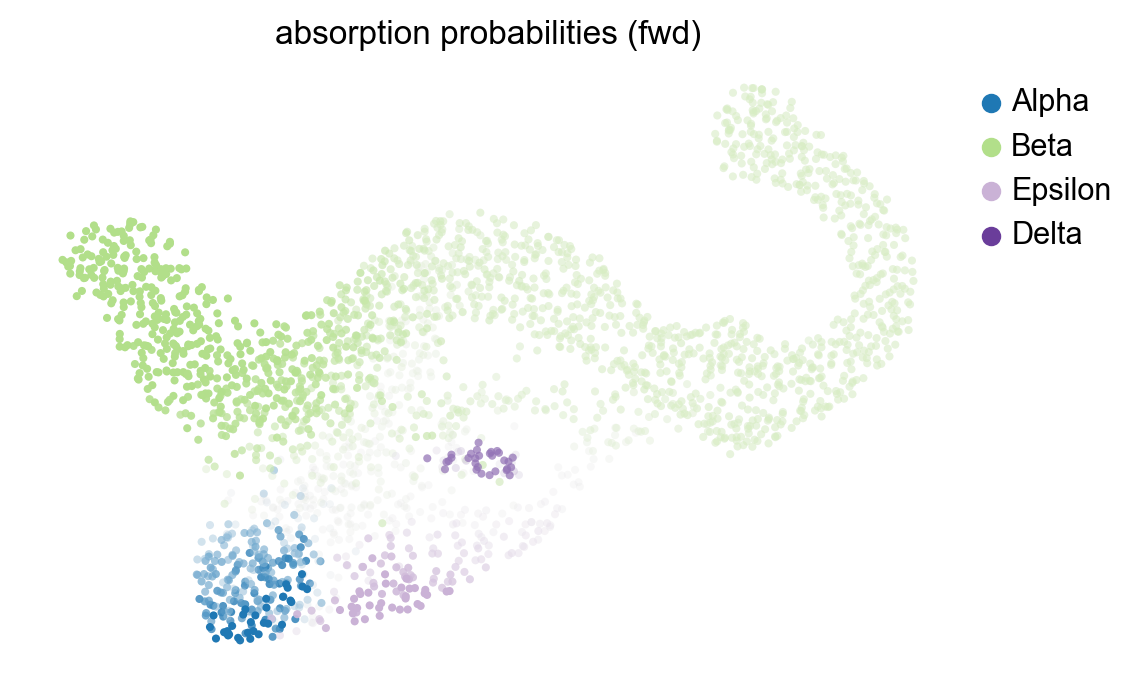

In [4]:
from cellrank.tl.estimators import GPCCA
weight_connectivities=0.2
mode="stochastic" 
n_jobs=40
softmax_scale=None

kernel = cr.tl.transition_matrix(adata, 
                                 weight_connectivities=weight_connectivities, 
                                 mode=mode, 
                                 n_jobs=n_jobs, 
                                 softmax_scale=softmax_scale)
g_fwd = GPCCA(kernel)
g_fwd.compute_schur(n_components=20)
n_states = 12
g_fwd.compute_macrostates(cluster_key='clusters', n_states=n_states)

g_fwd.set_terminal_states_from_macrostates(names=['Alpha', 'Beta', 'Epsilon', 'Delta'])
g_fwd.compute_absorption_probabilities()
cr.pl.lineages(adata)

## How the conversion is performed

<div class="alert alert-info">
    
**Note**

The follwoing section is not needed for your own analysis pipeline, it is rather an explanation of what is going on when running the function `scf.tl.cellrank_to_tree`

</div>

From the scvelo/CellRank pipeline, we are going to use the latent time estimate:

In [5]:
scv.tl.latent_time(adata)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


And a projection of the fate probabilities:

Solving TSP for `4` states


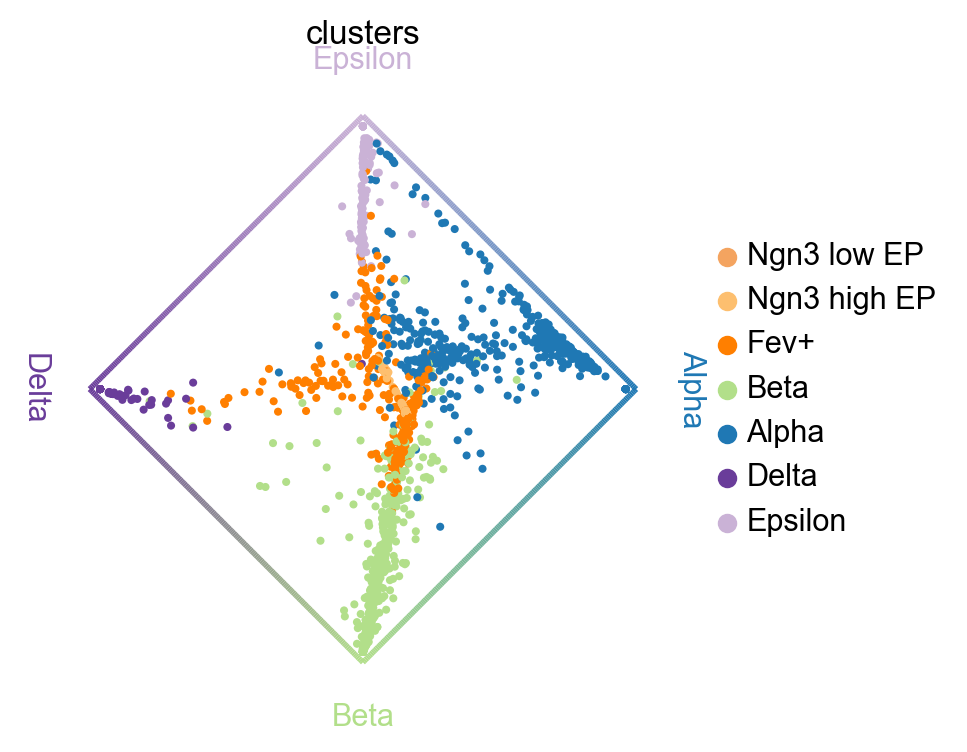

In [6]:
cr.pl.circular_projection(adata,"clusters",legend_loc="right")

This projection generated by`cr.pl.circular_projection` can be found under: 

In [7]:
adata.obsm["X_fate_simplex_fwd"]

array([[ 0.17818255, -0.13059981],
       [ 0.27014821,  0.11404904],
       [ 0.17351212, -0.09989089],
       ...,
       [ 0.15551545, -0.19602802],
       [ 0.83639188,  0.12376415],
       [ 0.00315303,  0.80043277]])

if we add a third dimension using our latent time or any pseudotime measurement, we obtain the following

In [8]:
adata.obsm["X_fates"]=np.concatenate([adata.obsm["X_fate_simplex_fwd"],
                                          adata.obs["latent_time"].values.reshape(-1,1)],axis=1)

In [9]:
adata.obsm["X_fates"]

array([[ 0.17818255, -0.13059981,  0.8600946 ],
       [ 0.27014821,  0.11404904,  0.88931465],
       [ 0.17351212, -0.09989089,  0.65183399],
       ...,
       [ 0.15551545, -0.19602802,  0.82558667],
       [ 0.83639188,  0.12376415,  0.85034744],
       [ 0.00315303,  0.80043277,  0.83946749]])

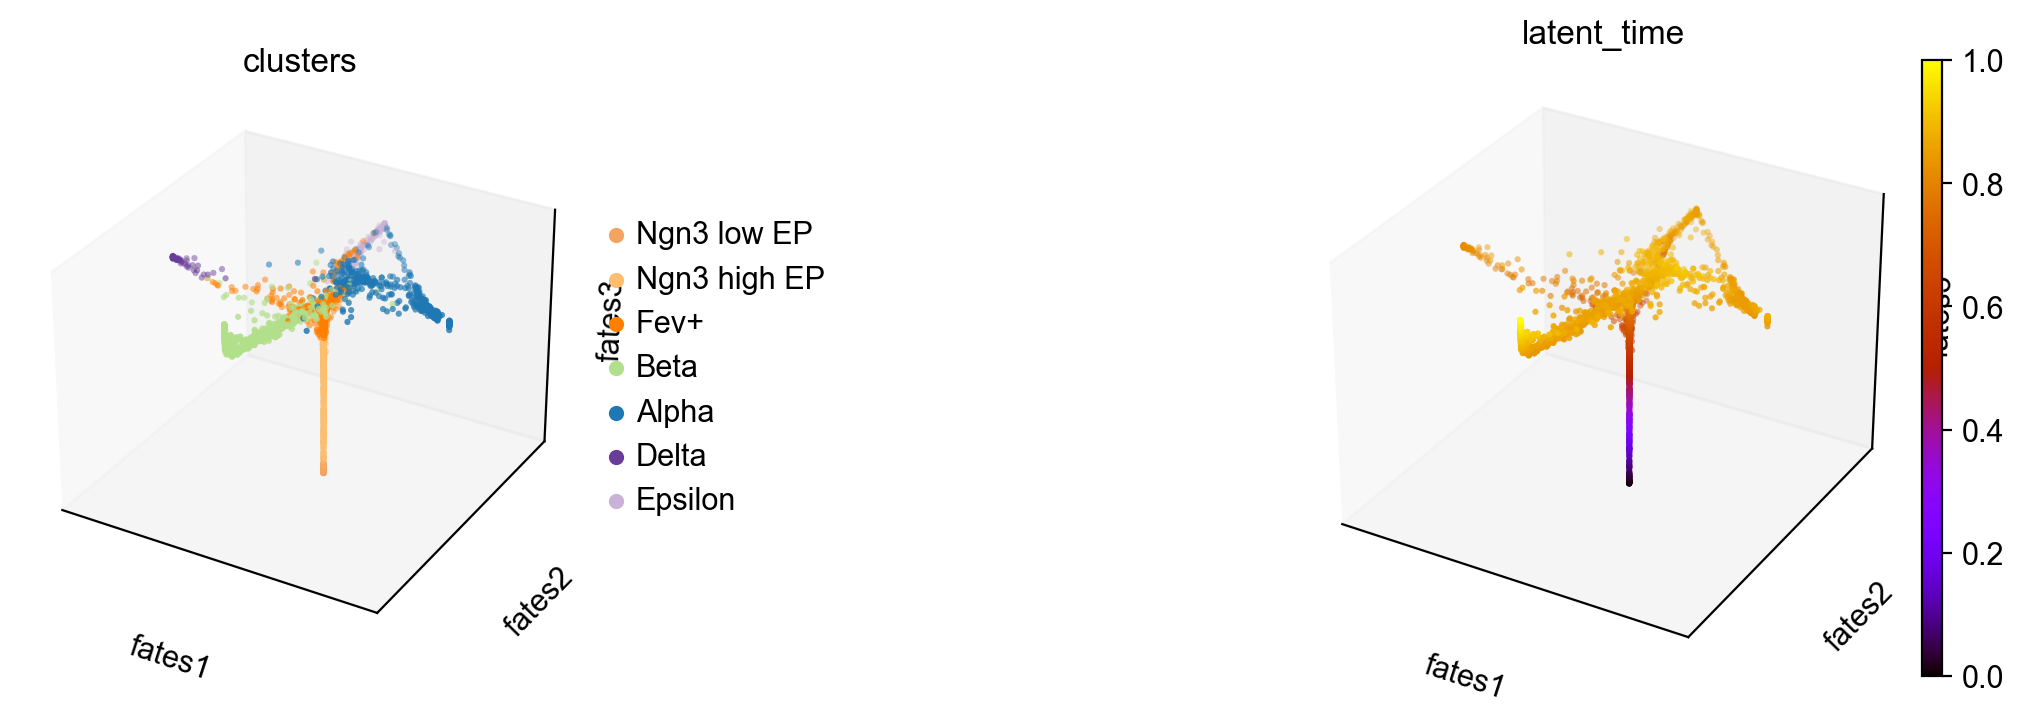

In [10]:
sc.pl.embedding(adata,basis="fates",projection="3d",color=["clusters","latent_time"],cmap="gnuplot")

We can then fit a principal tree in this 3d space! Given that each dimension is between 0 and 1, scFates should be able to  easily capture all the tips without having to tweak the parameters. 

What about the case of two terminal states only? 

No simplex representation can be generated, in such case, one column from `adata.obsm['to_terminal_states']` is used as 2d representation to be combined with the time estimate. 

What about multiple initial states? 

We could combine `adata.obsm['X_fate_simplex_fwd']` or `adata.obsm['to_terminal_states']` with `adata.obsm['X_fate_simplex_bwd']` or `adata.obsm['from_intial_states']` into a 4d representation, this will be implemented and tested in a future version.

## Converting CellRank results to a scFates principal tree

In [11]:
import scFates as scf

The following function recapitulate what we have done in the previous section, and perform tree inference, root selection and pseudotime calculation:

In [12]:
scf.tl.cellrank_to_tree(adata,time="latent_time",Nodes=300,seed=1,ppt_lambda=30)

Solving TSP for `4` states


Converting CellRank results to a principal tree --> with .obsm['X_fates'], created by combining:
    .obsm['X_fate_simplex_fwd'] (from cr.pl.circular_projection) and adata.obs['latent_time']

inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.1, lambda = 30, metric = euclidean
    fitting:  70%|███████   | 35/50 [00:01<00:00, 19.34it/s]
    converged
    finished (0:00:01) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] soft assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.

auto selecting a root using latent_time.

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal

We have now a fully converted principal tree, instead of using the distances on the tree as pseudotime values, we decided here to keep latent_time as the pseudotime measure. It is also possible to keep the tree distance based pseudotime value by setting the following parameter `reassign_pseudotime=False` when calling the conversion function.

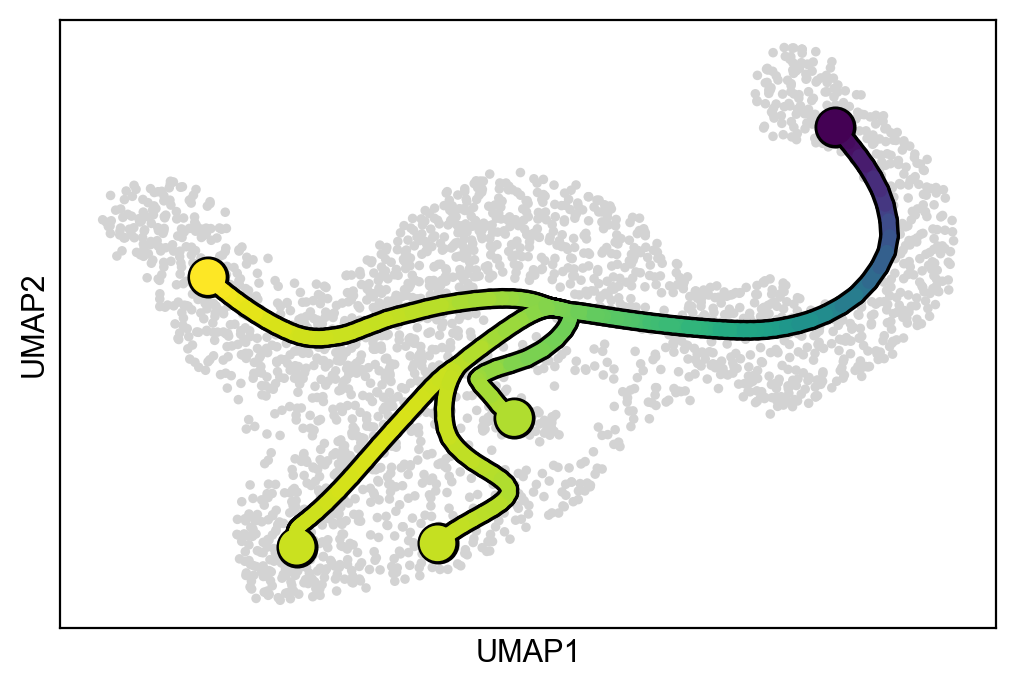

In [13]:
scf.pl.trajectory(adata)

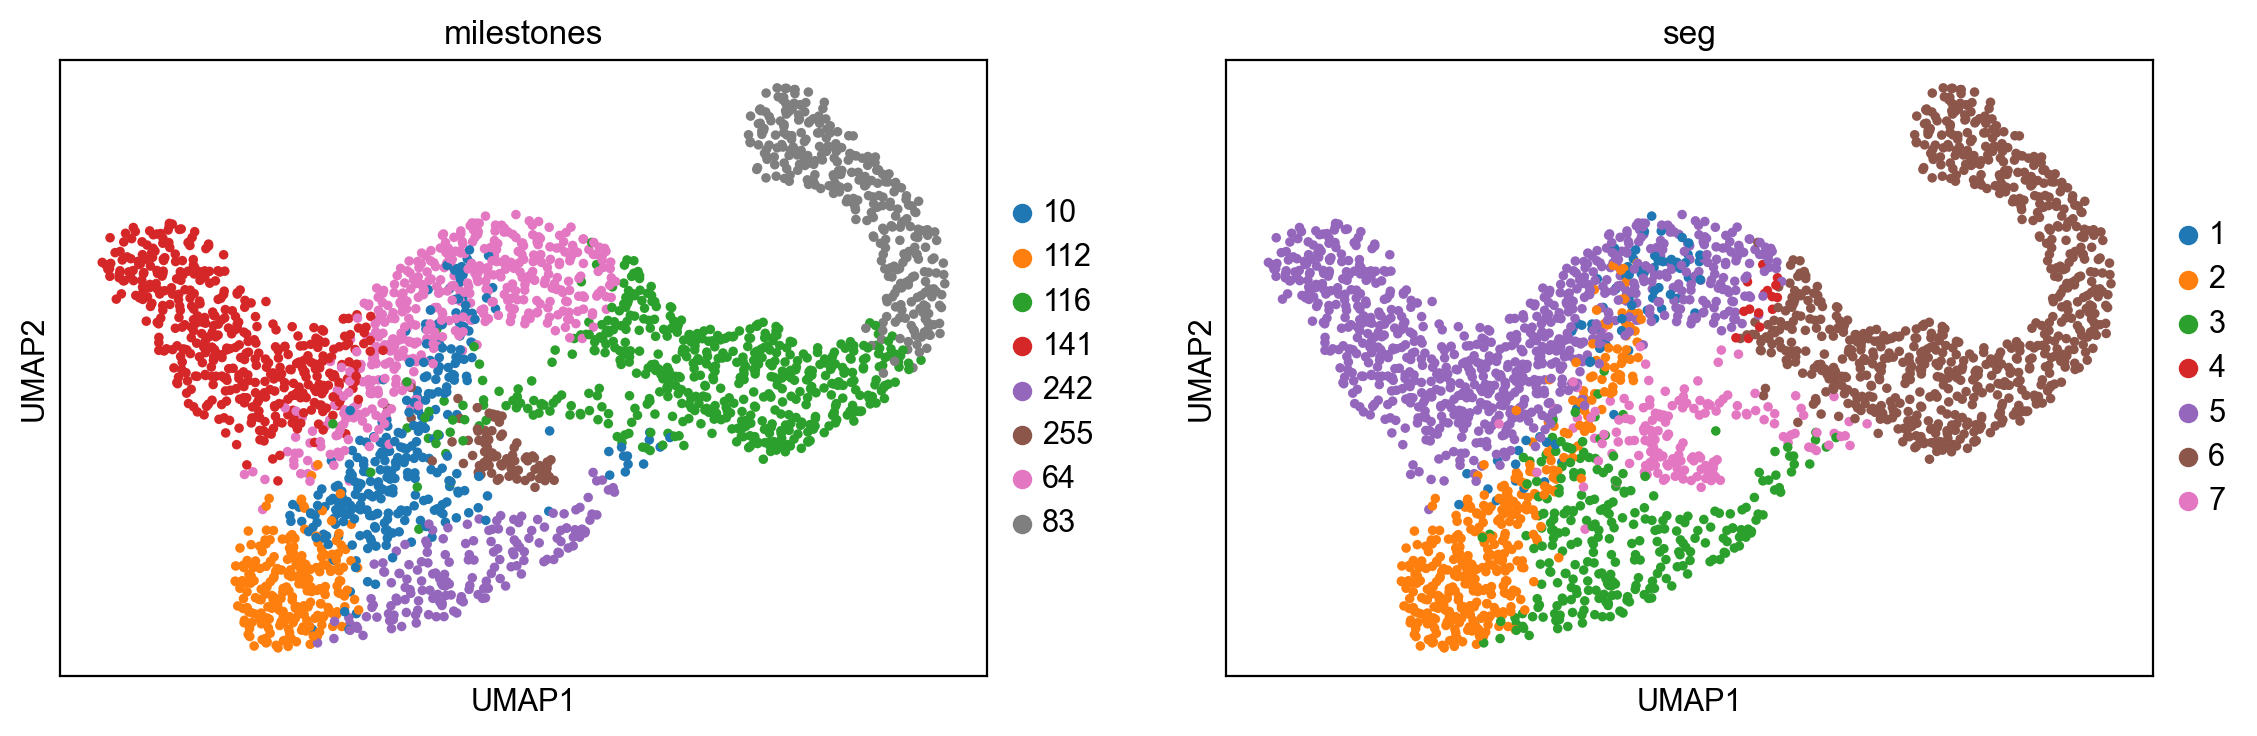

In [14]:
sc.pl.umap(adata,color=["milestones","seg"])

In [15]:
scf.tl.rename_milestones(adata,['Alpha_vs_Epsilon',
                                'Alpha',
                                'Delta_vs_rest',
                                'Beta',
                                'Epsilon',
                                'Delta',
                                'Beta_vs_rest',
                                'Progenitors'])

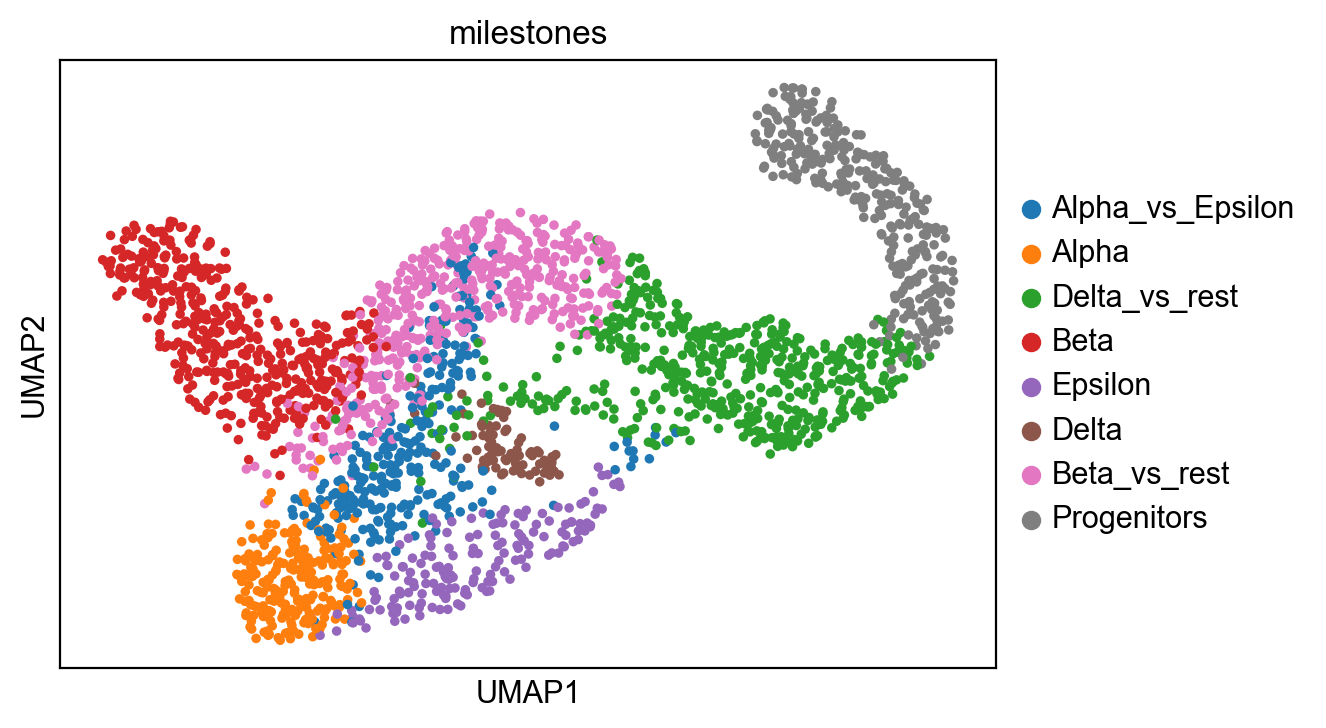

In [16]:
sc.pl.umap(adata,color=["milestones"])

Now that we have annotated our milestones, we can start performing downstream analysis!

### Test and fitting associated genes

In [17]:
adata=adata.raw.to_adata()

In [18]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

In [19]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 14939/14939 [01:53<00:00, 131.34it/s]
    found 2336 significant features (0:01:54) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


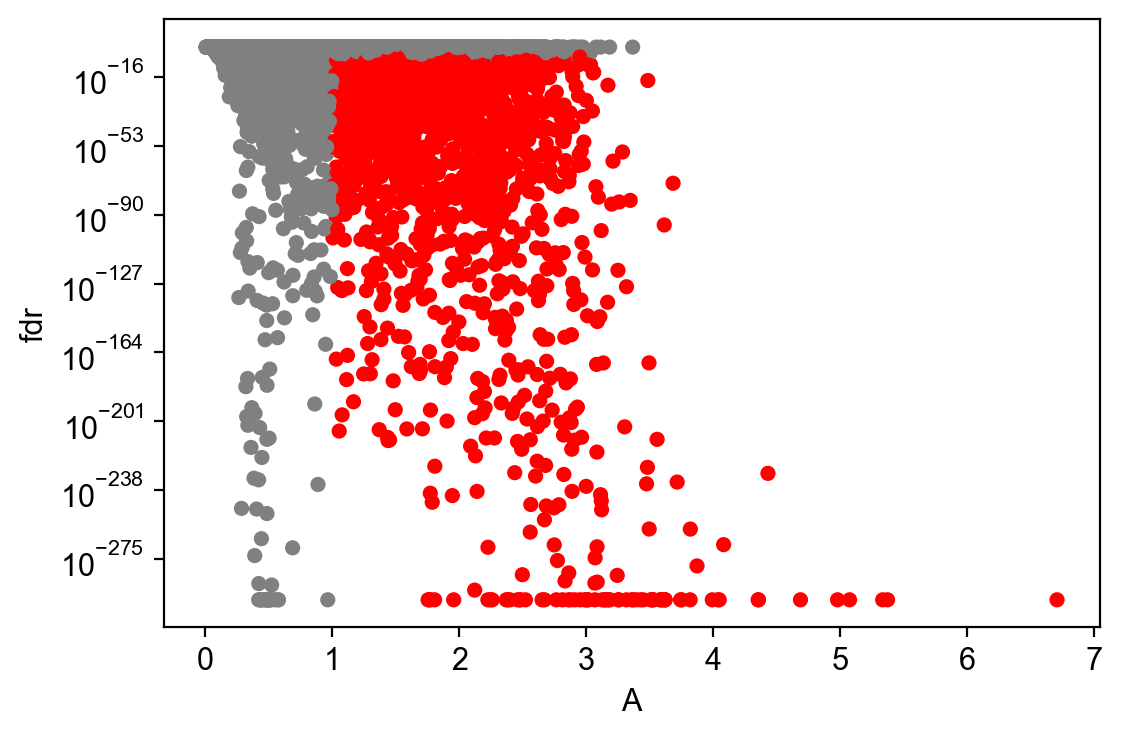

In [20]:
scf.pl.test_association(adata)

In [21]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 2336/2336 [00:35<00:00, 65.10it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:39) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


### Indentification of branch specific genes

In [22]:
root='Progenitors'
miles=['Alpha','Epsilon','Beta','Delta']

In [23]:
scf.tl.test_fork(adata,root_milestone=root,milestones=miles,n_jobs=20,rescale=True)

testing fork
    single mapping
    differential expression: 100%|██████████| 2336/2336 [01:17<00:00, 30.18it/s]
    test for upregulation for each leave vs root
    leave Delta: 100%|██████████| 288/288 [00:00<00:00, 1670.63it/s]
    finished (0:01:21) --> added 
    .uns['Progenitors->Alpha<>Epsilon<>Beta<>Delta']['fork'], DataFrame with fork test results.


In [24]:
scf.tl.branch_specific(adata,root_milestone=root,milestones=miles,effect=.05)

    branch specific features: Alpha: 80, Epsilon: 67, Beta: 21, Delta: 6
    finished --> updated 
    .uns['Progenitors->Alpha<>Epsilon<>Beta<>Delta']['fork'], DataFrame updated with additionnal 'branch' column.


In [25]:
scf.tl.activation(adata,root_milestone=root,milestones=miles,n_jobs=20,pseudotime_offset=0.1)

testing activation
    leave Delta: 100%|██████████| 6/6 [00:00<00:00, 3986.98it/s]
    threshold pseudotime is: 0.6381119642538609
    6 early and 74 late features specific to leave Alpha
    20 early and 47 late features specific to leave Epsilon
    7 early and 14 late features specific to leave Beta
    4 early and 2 late features specific to leave Delta
    finished (0:00:03) --> updated 
    .uns['Progenitors->Alpha<>Epsilon<>Beta<>Delta']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


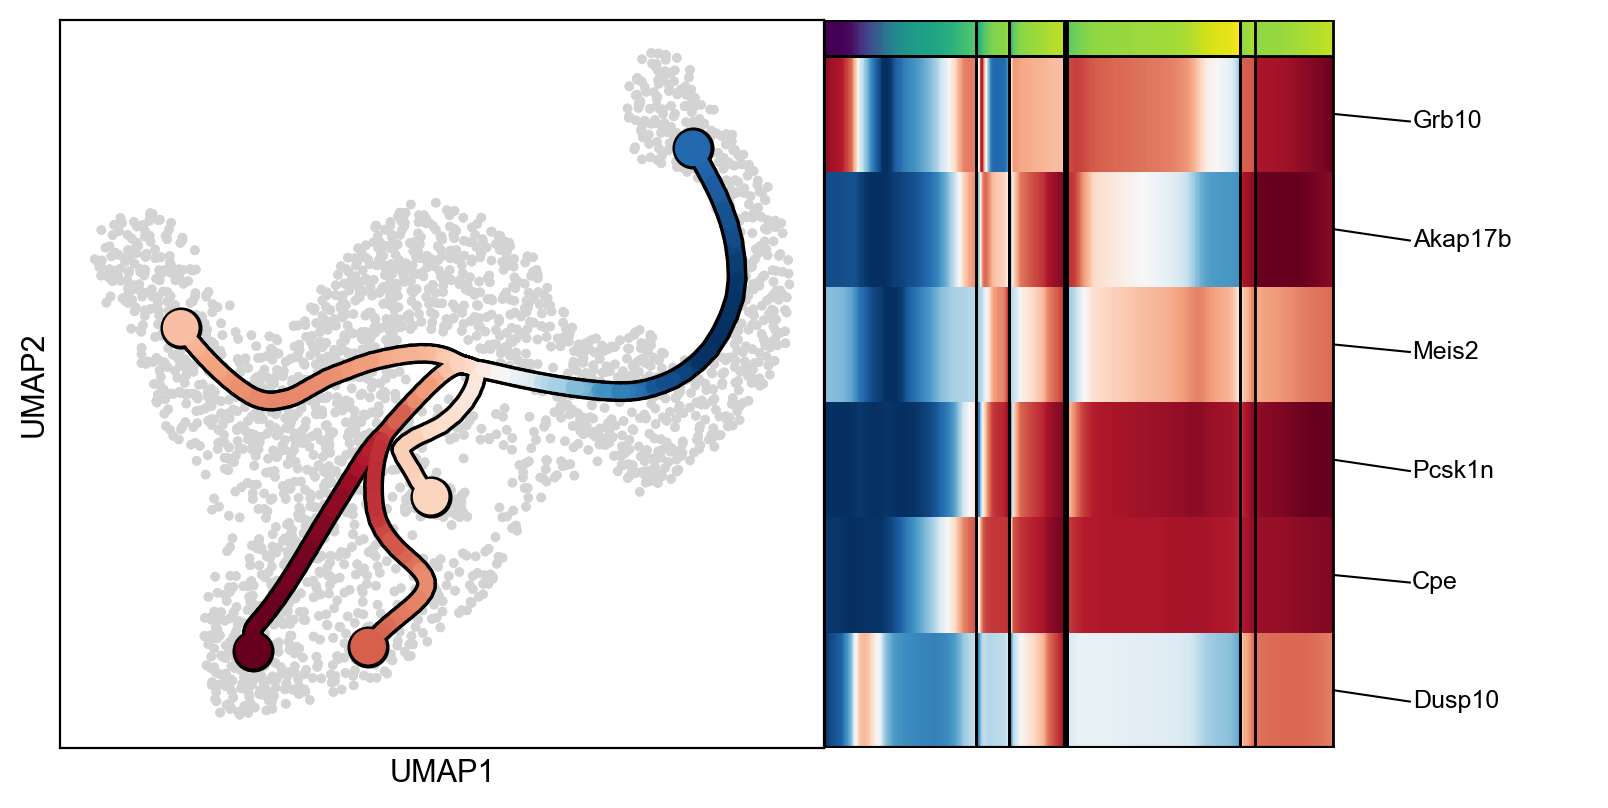

In [26]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Alpha",module="early")

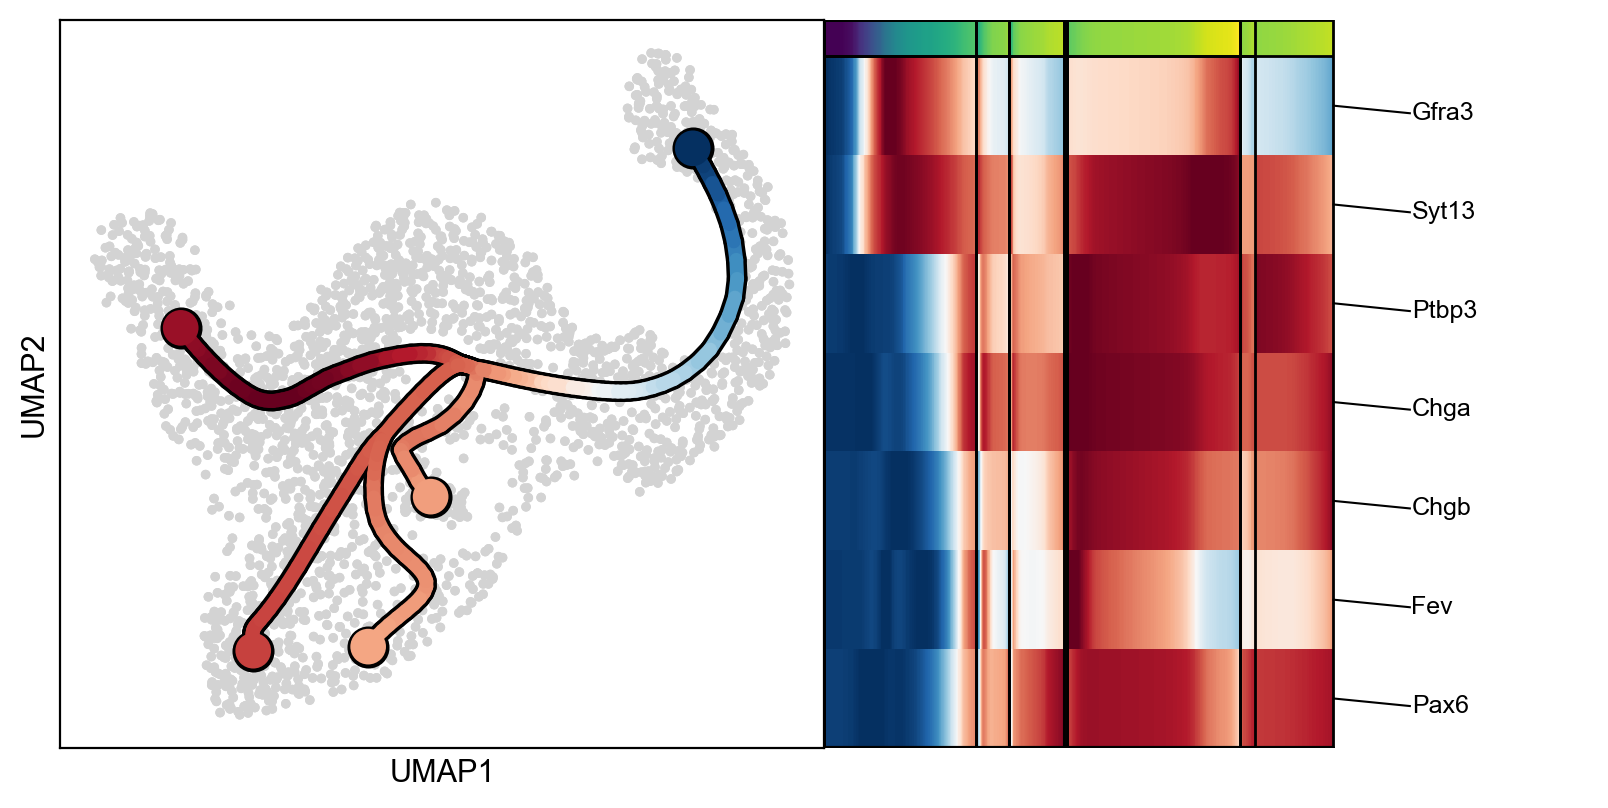

In [27]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Beta",module="early")

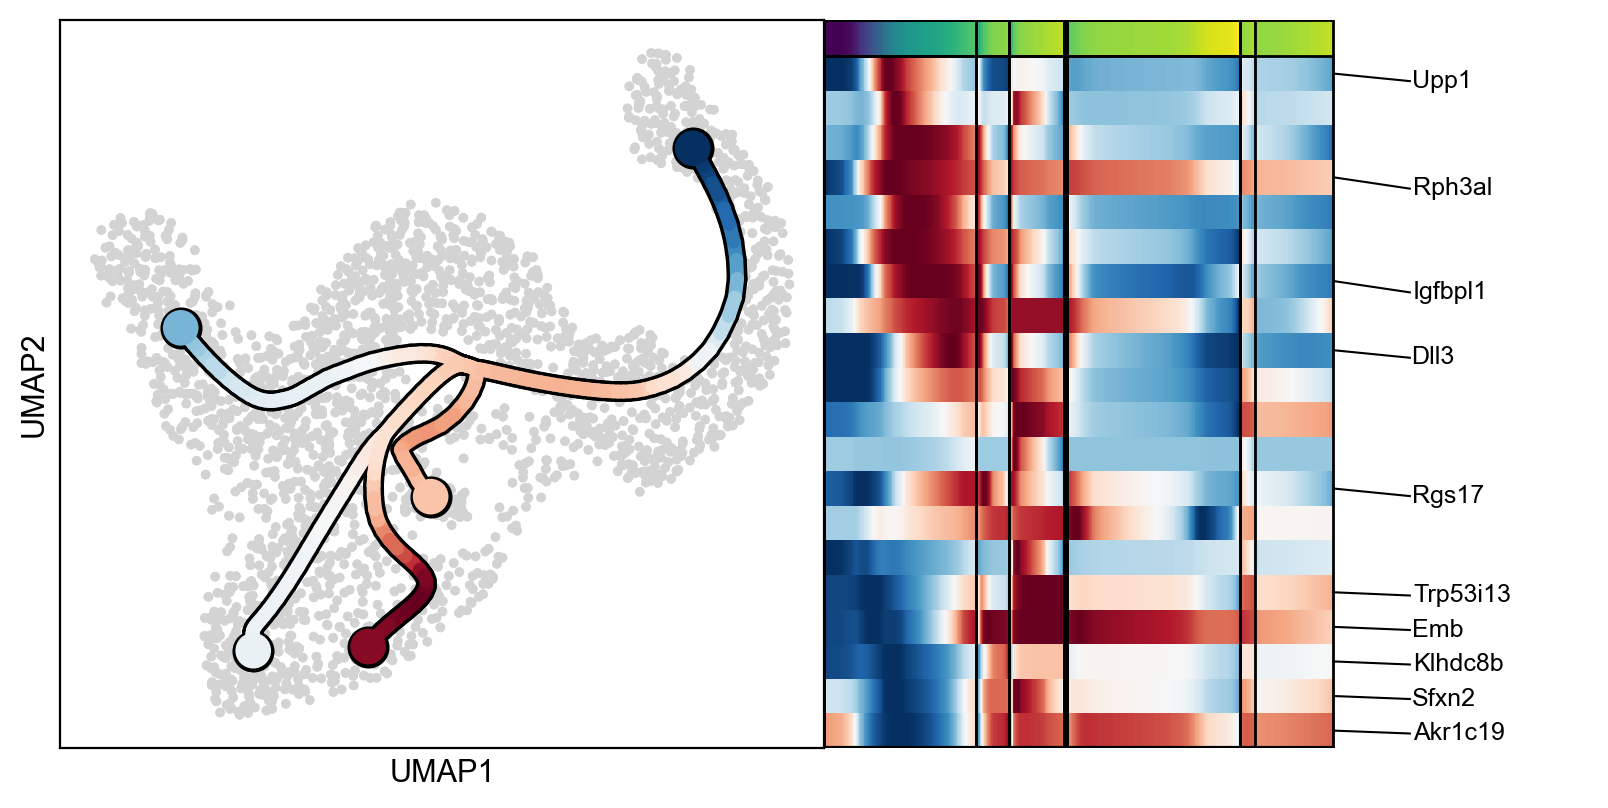

In [28]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Epsilon",module="early")

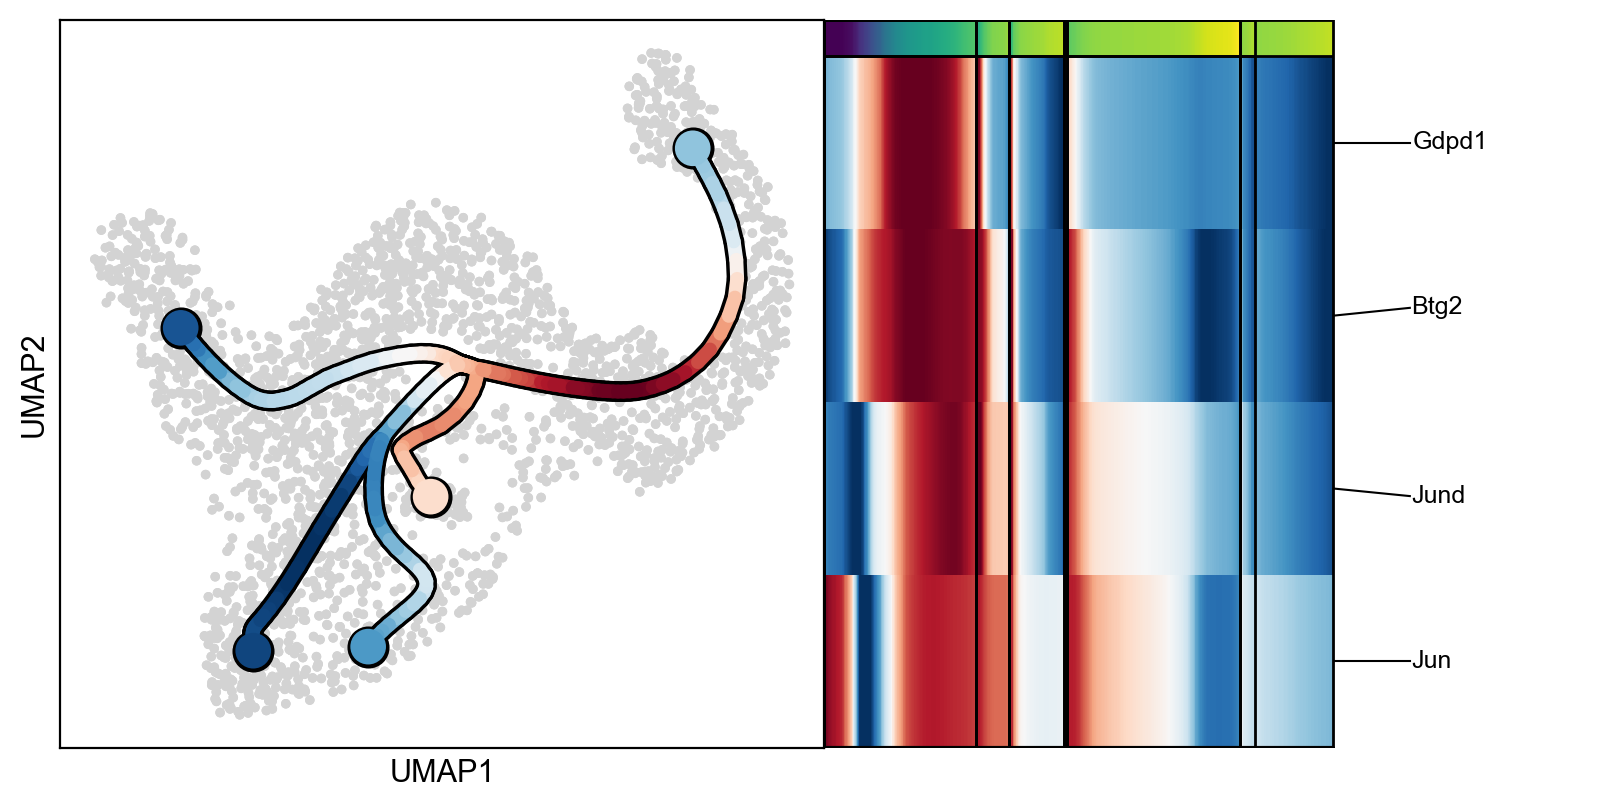

In [29]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Delta",module="early")